In [1]:
import os 
import sys

paths_to_add = [
    os.path.abspath(os.path.join('../..')),  
    os.path.abspath(os.path.join('..'))  
]

sys.path.extend(path for path in paths_to_add if path not in sys.path)

In [2]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
import numpy as np
import scipy.stats
from jax import random
import matplotlib.pyplot as plt

from fbpinns import networks


In [3]:
@staticmethod
def _rectangle_samplerND(key, sampler, xmin, xmax, batch_shape):
        "Get flattened samples of x in a rectangle, either on mesh or random"

        assert xmin.shape == xmax.shape
        assert xmin.ndim == 1
        xd = len(xmin)
        assert len(batch_shape) == xd

        if not sampler in ["grid", "uniform", "sobol", "halton"]:
            raise ValueError("ERROR: unexpected sampler")

        if sampler == "grid":
            xs = [jnp.linspace(xmin, xmax, b) for xmin,xmax,b in zip(xmin, xmax, batch_shape)]
            xx = jnp.stack(jnp.meshgrid(*xs, indexing="ij"), -1)# (batch_shape, xd)
            x_batch = xx.reshape((-1, xd))
        else:
            if sampler == "halton":
                # use scipy as not implemented in jax (!)
                r = scipy.stats.qmc.Halton(xd)
                s = r.random(np.prod(batch_shape))
            elif sampler == "sobol":
                r = scipy.stats.qmc.Sobol(xd)
                s = r.random(np.prod(batch_shape))
            elif sampler == "uniform":
                s = jax.random.uniform(key, (np.prod(batch_shape), xd))

            xmin, xmax = xmin.reshape((1,-1)), xmax.reshape((1,-1))
            x_batch = xmin + (xmax - xmin)*s

        return jnp.array(x_batch)

def phi(xi, eta):
    phiA = 0.25 * (1 - xi) * (1 - eta)
    phiB = 0.25 * (1 + xi) * (1 - eta)
    phiC = 0.25 * (1 + xi) * (1 + eta)
    phiD = 0.25 * (1 - xi) * (1 + eta)
    return jnp.array([phiA, phiB, phiC, phiD])

def transformation_matrix(xi, eta):
    phi_values = phi(xi, eta)
    
    t_mat = jnp.zeros((2, 8))
    t_mat = t_mat.at[0, :4].set(phi_values)
    t_mat = t_mat.at[1, 4:].set(phi_values)
    
    return t_mat

In [4]:
key = random.PRNGKey(0)
# key, subkey = random.split(key)
sampler = 'halton'
xmin, xmax = jnp.array([-1,-1]), jnp.array([1,1])
batch_shape = (10,20)

In [5]:
x_batch = _rectangle_samplerND(key, sampler, xmin, xmax, batch_shape)

In [6]:
# from fbpinns.domains import RectangularDomainND

# domain = RectangularDomainND
x_batch.shape

(200, 2)

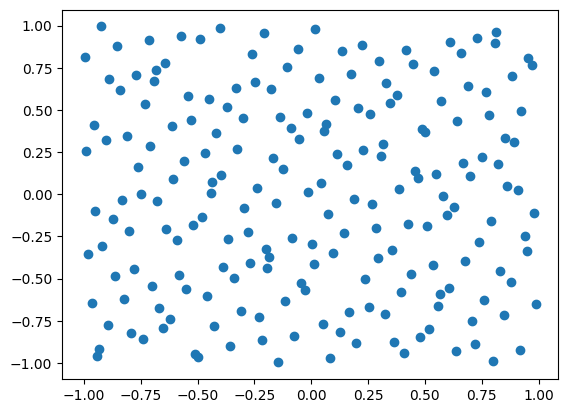

In [7]:
plt.scatter(x_batch[:, 0:1], x_batch[:,1:2])

In [8]:
xs = np.array([0, 48, 48, 0])
ys = np.array([0, 44, 60, 44])
x_hat = np.array([xs,ys]).reshape(-1)

global_coordinates = np.zeros((len(x_batch), 2))

# Transform each point in x_batch to the global coordinate system
for i, (xi, eta) in enumerate(x_batch):
    t_mat = transformation_matrix(xi, eta)
    global_coordinate = t_mat @ x_hat
    global_coordinates[i] = global_coordinate

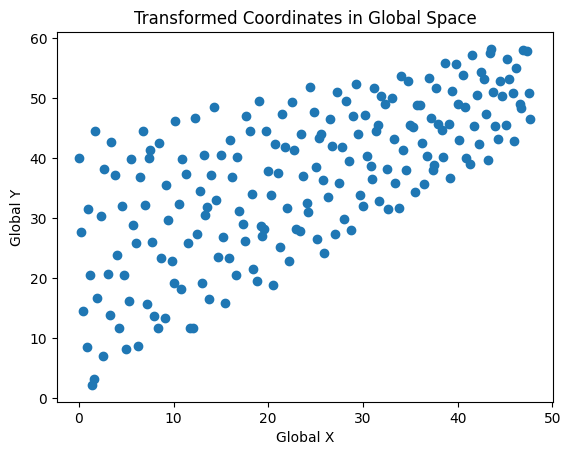

In [9]:
plt.scatter(global_coordinates[:, 0], global_coordinates[:, 1])
plt.xlabel('Global X')
plt.ylabel('Global Y')
plt.title('Transformed Coordinates in Global Space')
plt.show()

In [10]:
out = transformation_matrix(-1,-1) @ x_hat
out

Array([0., 0.], dtype=float32)

In [11]:
corners = jnp.array([(0, 0), (0, 44.0), (48.0, 60.0), (48.0, 44.0)])
print(corners, corners.shape[1])

[[ 0.  0.]
 [ 0. 44.]
 [48. 60.]
 [48. 44.]] 2


In [12]:
from fbpinns.domains import Domain

class CooksDomainND(Domain):
    @staticmethod
    def init_params(corners):
        xd = corners.shape[1]
        static_params = {
            "xd" : xd,
            "corners" : jnp.array(corners)
        }
        return static_params, {}
    @staticmethod
    def phi(xi, eta):
        phiA = 0.25 * (1 - xi) * (1 - eta)
        phiB = 0.25 * (1 + xi) * (1 - eta)
        phiC = 0.25 * (1 + xi) * (1 + eta)
        phiD = 0.25 * (1 - xi) * (1 + eta)
        return jnp.array([phiA, phiB, phiC, phiD])
    @staticmethod
    def transformation_matrix(xi, eta, x_hat):
        phi_values = CooksDomainND.phi(xi, eta)
        
        t_mat = jnp.zeros((2, 8))
        t_mat = t_mat.at[0, :4].set(phi_values)
        t_mat = t_mat.at[1, 4:].set(phi_values)
        transformed = jnp.dot(t_mat, x_hat)
        return transformed
    
    @staticmethod
    def _rectangle_samplerND(key, sampler, xmin, xmax, batch_shape):
        "Get flattened samples of x in a rectangle, either on mesh or random"

        assert xmin.shape == xmax.shape
        assert xmin.ndim == 1
        xd = len(xmin)
        assert len(batch_shape) == xd

        if not sampler in ["grid", "uniform", "sobol", "halton"]:
            raise ValueError("ERROR: unexpected sampler")

        if sampler == "grid":
            xs = [jnp.linspace(xmin, xmax, b) for xmin,xmax,b in zip(xmin, xmax, batch_shape)]
            xx = jnp.stack(jnp.meshgrid(*xs, indexing="ij"), -1)# (batch_shape, xd)
            x_batch = xx.reshape((-1, xd))
        else:
            if sampler == "halton":
                # use scipy as not implemented in jax (!)
                r = scipy.stats.qmc.Halton(xd)
                s = r.random(np.prod(batch_shape))
            elif sampler == "sobol":
                r = scipy.stats.qmc.Sobol(xd)
                s = r.random(np.prod(batch_shape))
            elif sampler == "uniform":
                s = jax.random.uniform(key, (np.prod(batch_shape), xd))

            xmin, xmax = xmin.reshape((1,-1)), xmax.reshape((1,-1))
            x_batch = xmin + (xmax - xmin)*s

        return jnp.array(x_batch)
    
    @staticmethod
    def sample_interior(all_params, key, sampler, batch_shape):
        # xd = all_params["static"]["domain"]["xd"]
        corners = all_params["static"]["domain"]["corners"]
        x_hat = jnp.concatenate([corners[:, 0], corners[:, 1]])
        # isoparametric element
        xmin, xmax = jnp.array([-1,-1]), jnp.array([1,1])
        x_batch_iso =  CooksDomainND._rectangle_samplerND(key, sampler, xmin, xmax, batch_shape)
        return vmap(CooksDomainND.transformation_matrix, in_axes=(0, 0, None))(x_batch_iso[:, 0], x_batch_iso[:, 1], x_hat)
    
    @staticmethod
    def sample_boundaries(all_params, key, sampler, batch_shapes):
        xmin, xmax = jnp.array([-1,-1]), jnp.array([1,1]) #isoparametric_elememnt

        xd = all_params["static"]["domain"]["xd"]
        corners = all_params["static"]["domain"]["corners"]
        x_hat = jnp.concatenate([corners[:, 0], corners[:, 1]])

        assert len(batch_shapes) == 2*xd# total number of boundaries

        x_batches = []
        for i in range(xd):
            ic = jnp.array(list(range(i))+list(range(i+1,xd)), dtype=int)
            for j,v in enumerate([xmin[i], xmax[i]]):
                batch_shape = batch_shapes[2*i+j]
                if len(ic):
                    xmin_, xmax_ = xmin[ic], xmax[ic]
                    key, subkey = jax.random.split(key)
                    x_batch_ = CooksDomainND._rectangle_samplerND(subkey, sampler, xmin_, xmax_, batch_shape)# (n, xd-1)
                    x_batch = v*jnp.ones((jnp.prod(jnp.array(batch_shape)),xd), dtype=float)
                    x_batch = x_batch.at[:,ic].set(x_batch_)
                else:
                    assert len(batch_shape) == 1
                    x_batch = v*jnp.ones(batch_shape+(1,), dtype=float)
                x_batch = vmap(CooksDomainND.transformation_matrix, in_axes=(0, 0, None))(x_batch[:, 0], x_batch[:, 1], x_hat)
                x_batches.append(x_batch)
        return x_batches
    
    @staticmethod
    def norm_fn(all_params, x):
        xmin, xmax = jnp.array([-1,-1]), jnp.array([1,1]) #isoparametric_elememnt
        # xmin, xmax = all_params["static"]["domain"]["xmin"], all_params["static"]["domain"]["xmax"]
        x_hat = jnp.concatenate([corners[:, 0], corners[:, 1]])
        mu, sd = (xmax+xmin)/2, (xmax-xmin)/2
        x = networks.norm(mu, sd, x)
        return x

In [13]:
key = jax.random.PRNGKey(0)
all_params = {
    "static": {
        "domain": {
            "xd": 2,
            "corners": jnp.array([(0, 0), (0, 44.0), (48.0, 60.0), (48.0, 44.0)]),
        }
    }
}
sampler = 'uniform'  # for example
batch_shape = (10,20)  # for example
x_batch = CooksDomainND.sample_interior(all_params, key, sampler, batch_shape)

batch_shapes = ((10,),(10,),(10,),(10,)) # bottom, top, left, right
x_boundaries = CooksDomainND.sample_boundaries(all_params, key, 'grid', batch_shapes)

(10, 2)
(10, 2)
(10, 2)
(10, 2)


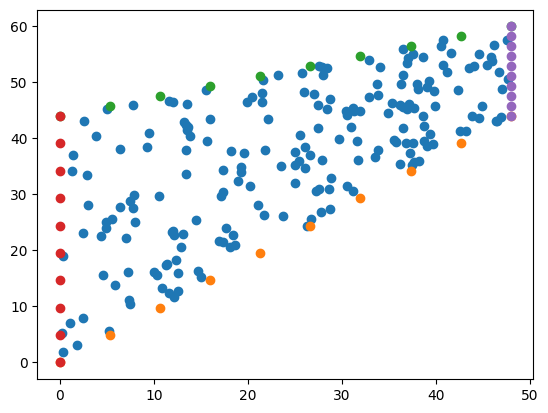

In [14]:
plt.scatter(x_batch[:, 0:1], x_batch[:, 1:2])
for x_batch_b in x_boundaries:
        print(x_batch_b.shape)
        plt.scatter(x_batch_b[:,0], x_batch_b[:,1], )

In [15]:
bottom, top, left, right = x_boundaries
top

Array([[ 0.      , 44.      ],
       [ 5.333333, 45.77778 ],
       [10.666666, 47.555553],
       [15.999999, 49.333332],
       [21.333332, 51.11111 ],
       [26.666668, 52.88889 ],
       [32.      , 54.666668],
       [37.333336, 56.444443],
       [42.666668, 58.22222 ],
       [48.      , 60.      ]], dtype=float32)

In [16]:
# Calculate normal vector
import numpy as np

A = bottom[0, :]
B = bottom[1, :]

AB = B - A

N_ccw = np.array([-AB[1], AB[0]])  # Counter-clockwise rotation
N_cw = np.array([AB[1], -AB[0]])   # Clockwise rotation

# Normalize 
N_ccw_unit = N_ccw / np.linalg.norm(N_ccw)
N_cw_unit = N_cw / np.linalg.norm(N_cw)

N_ccw_unit, N_cw_unit

(array([-0.67572457,  0.7371541 ], dtype=float32),
 array([ 0.67572457, -0.7371541 ], dtype=float32))

In [17]:
# Normal vec bottom
A = bottom[0, :]
B = bottom[1, :]

AB = B - A

N_ccw = np.array([-AB[1], AB[0]])  # Counter-clockwise rotation
N_cw = np.array([AB[1], -AB[0]])   # Clockwise rotation

# Normalize
N_ccw_unit = N_ccw / np.linalg.norm(N_ccw)
N_cw_unit = N_cw / np.linalg.norm(N_cw)

N_ccw_unit, N_cw_unit

(array([-0.67572457,  0.7371541 ], dtype=float32),
 array([ 0.67572457, -0.7371541 ], dtype=float32))

In [18]:
print(x_batch.min(axis=0))
print(x_batch.max(axis=0))

[0.2406578 1.9032604]
[47.663857 57.567757]
